In [1]:
import sys
sys.path.append('../')
from mnist_reader import load_mnist_df,show_mnist_image

import pandas as pd
import numpy as np

import torch
import torch.utils.data 
from torch.autograd.variable import Variable

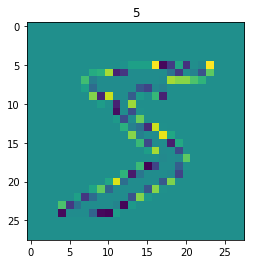

In [2]:
mnist_df = load_mnist_df('../data/')
show_mnist_image(mnist_df,index=0)

In [3]:
mnist = torch.tensor(mnist_df.drop(labels='label',axis=1).values,dtype=torch.float32)

In [4]:
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [5]:
def noise(size):
    """
    Generates a 1-d vector of gaussian sampled random values
    """
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [6]:
class DiscriminatorNet(torch.nn.Module):
    """
    A discriminator neural network for MNIST dataset
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = torch.nn.Sequential( 
            torch.nn.Linear(n_features, 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.hidden1 = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
     
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet()

In [7]:
class GeneratorNet(torch.nn.Module):
    """
    A Generator neural network for MNIST dataset
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = torch.nn.Sequential(
            torch.nn.Linear(n_features, 256),
            torch.nn.LeakyReLU(0.2)
        )
        self.hidden1 = torch.nn.Sequential(            
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU(0.2)
        )
        self.hidden2 = torch.nn.Sequential(
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(0.2)
        )
        
        self.out = torch.nn.Sequential(
            torch.nn.Linear(1024, n_out),
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [8]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

In [9]:
loss = torch.nn.BCELoss()

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [11]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)

0


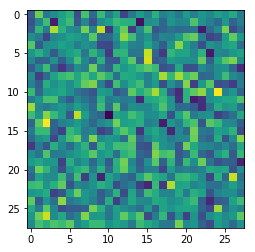

1


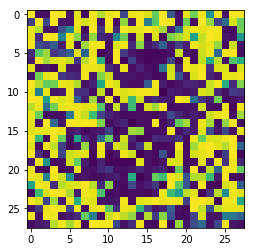

2


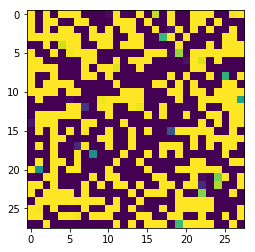

3


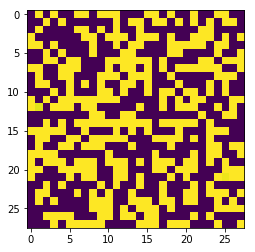

4


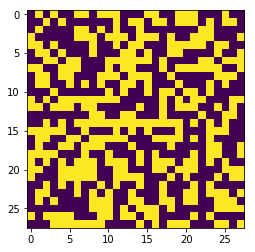

5


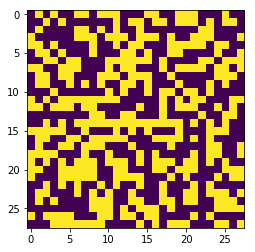

6


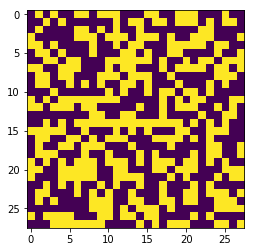

7


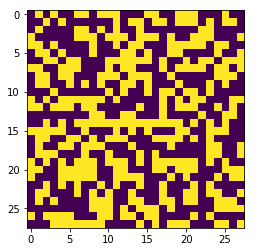

8


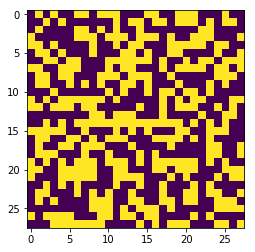

9


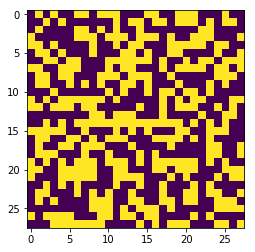

10


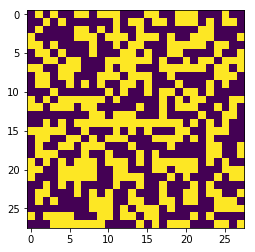

11


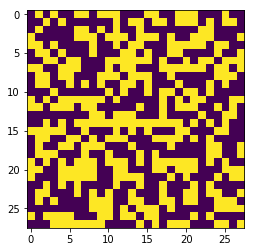

12


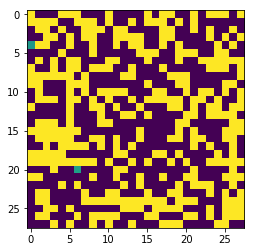

13


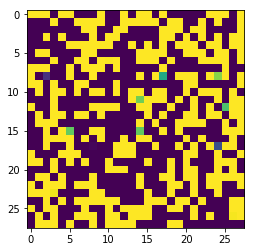

14


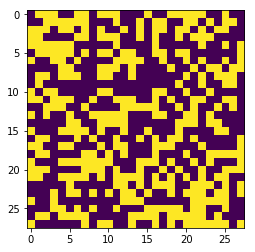

15


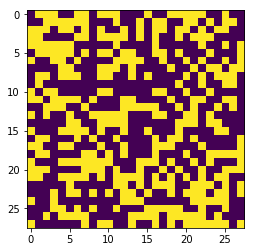

16


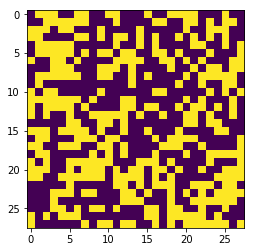

17


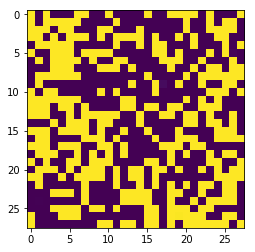

18


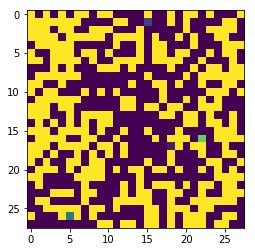

19


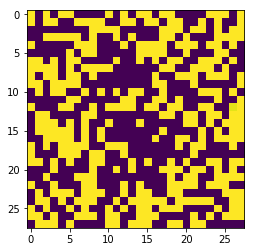

20


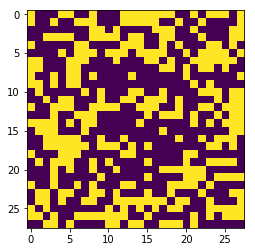

21


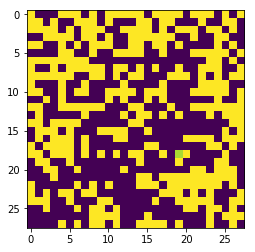

22


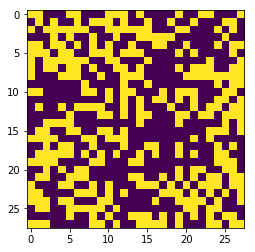

23


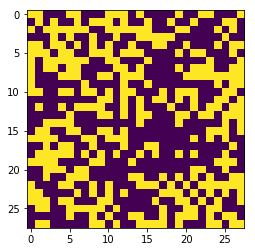

24


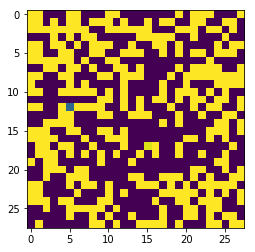

25


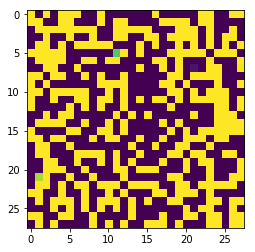

26


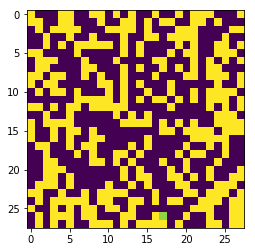

27


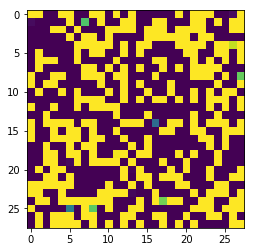

28


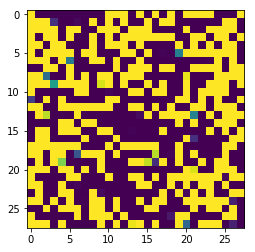

29


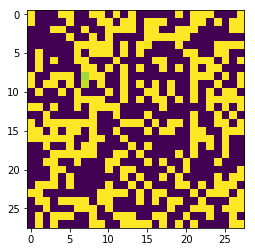

30


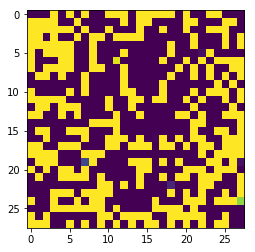

31


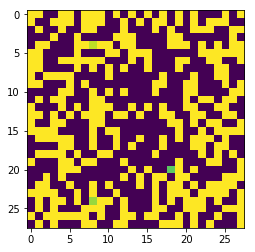

32


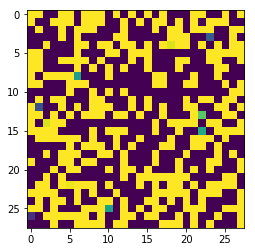

33


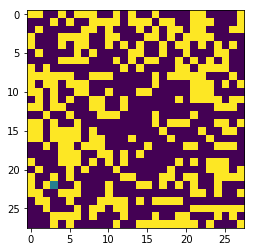

34


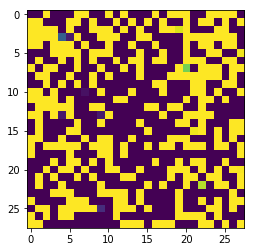

35


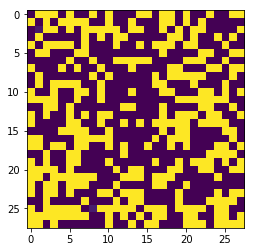

36


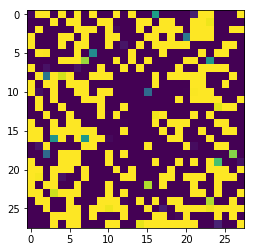

37


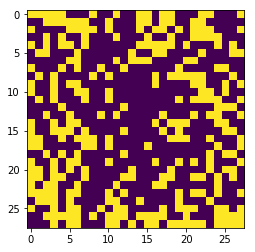

38


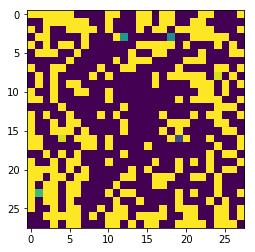

39


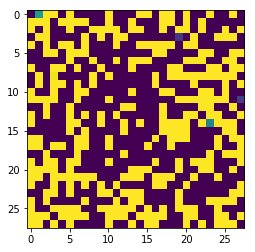

40


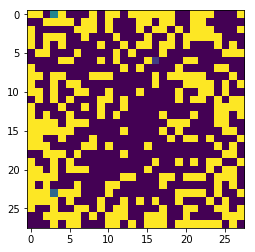

41


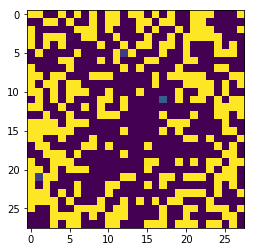

42


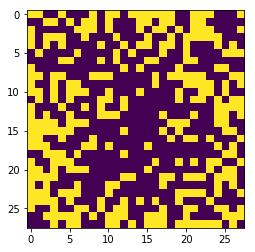

43


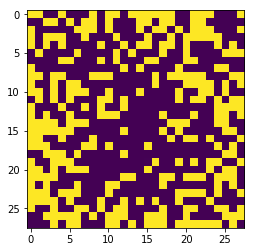

44


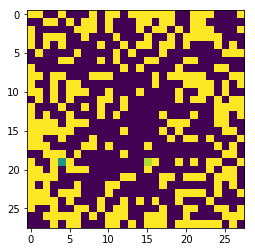

45


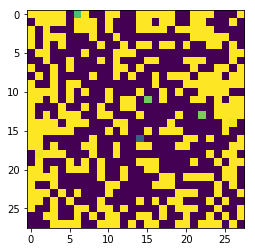

46


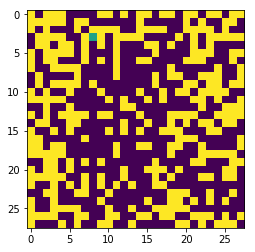

47


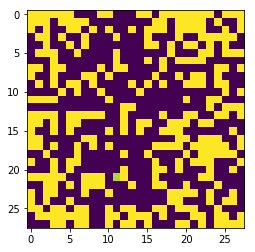

48


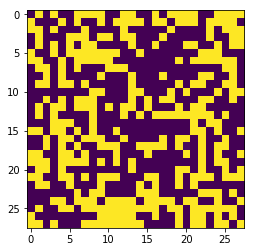

49


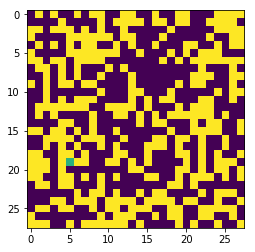

50


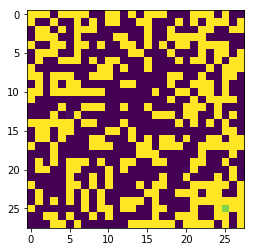

51


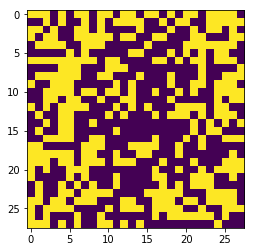

52


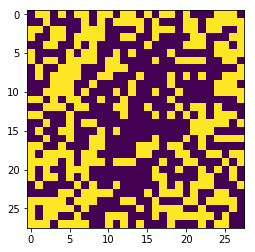

53


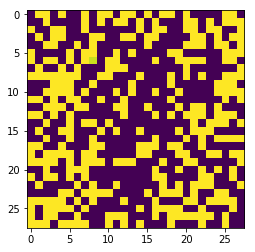

54


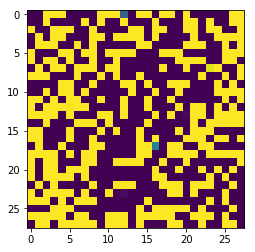

55


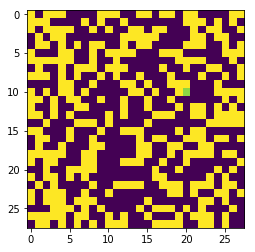

56


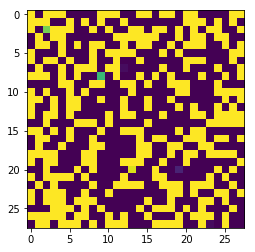

57


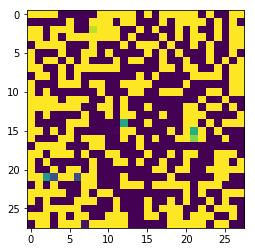

58


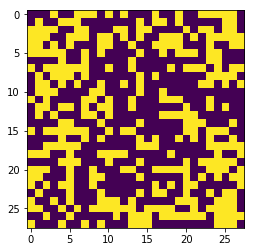

59


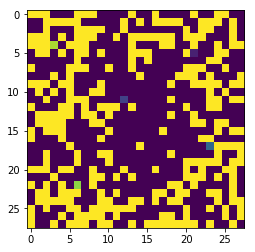

60


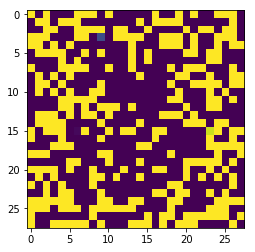

61


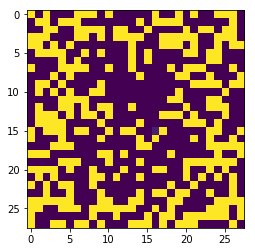

62


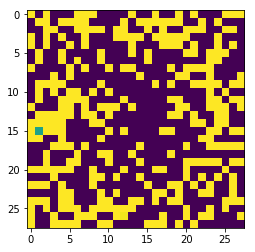

63


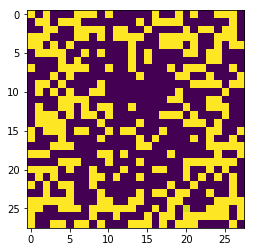

64


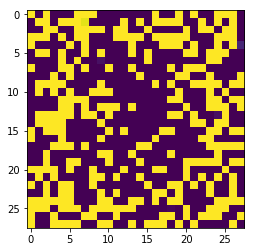

65


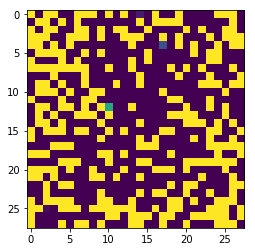

66


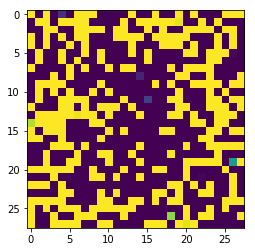

67


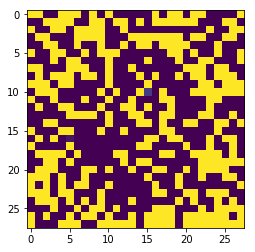

68


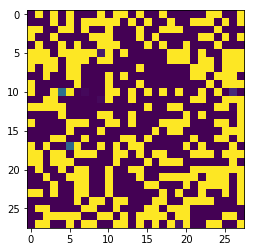

69


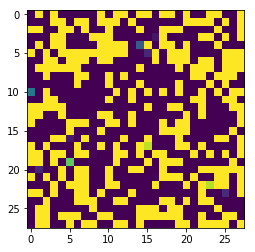

70


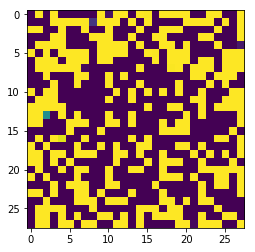

71


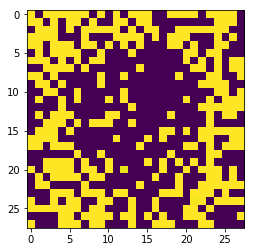

72


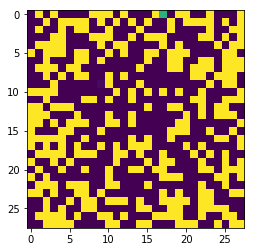

73


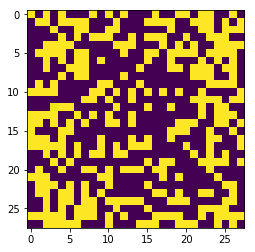

74


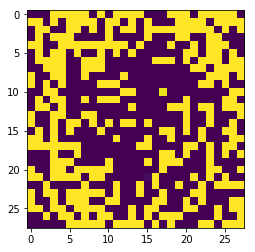

75


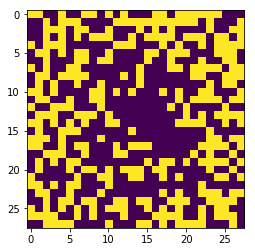

76


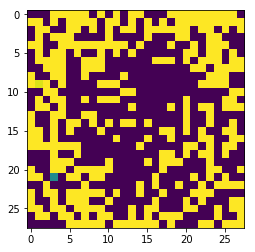

77


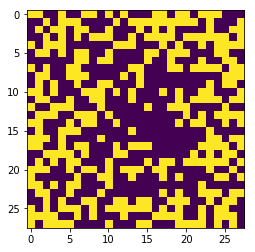

78


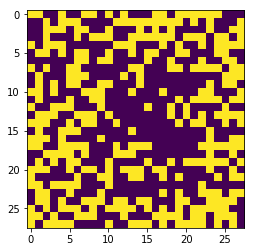

79


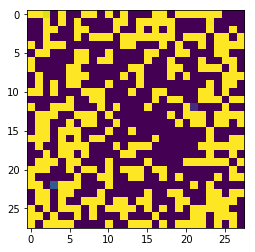

80


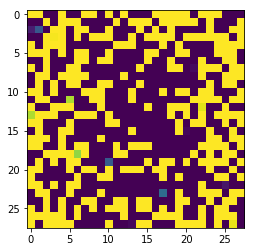

81


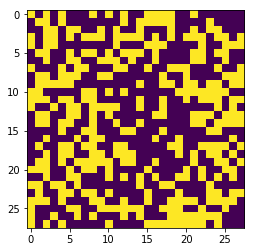

82


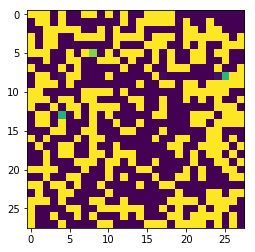

83


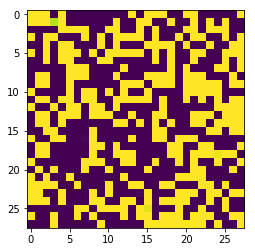

84


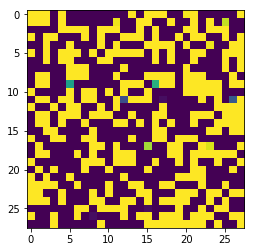

85


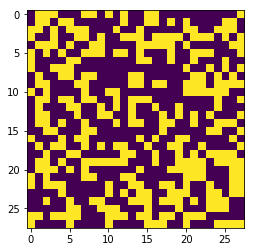

86


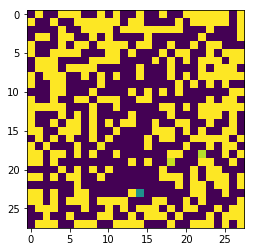

87


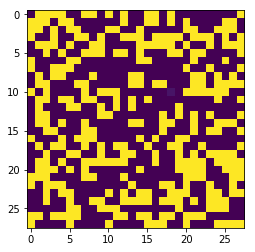

88


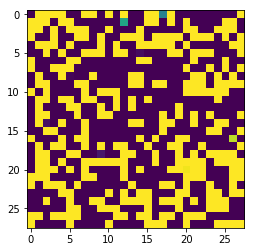

89


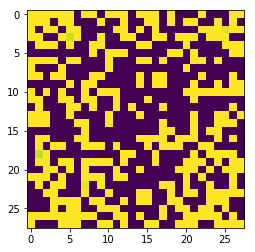

90


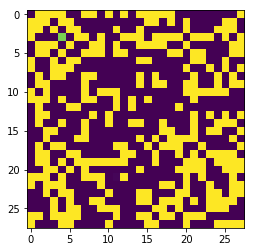

91


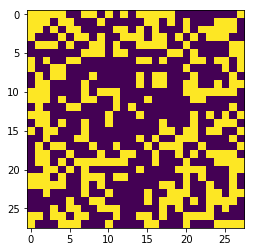

92


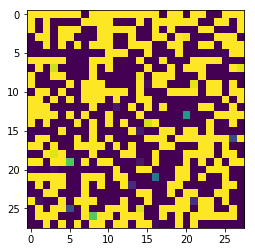

93


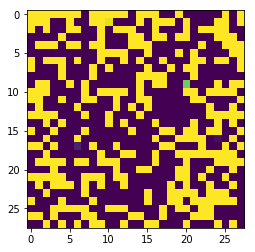

94


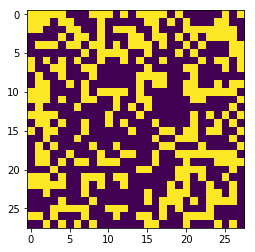

95


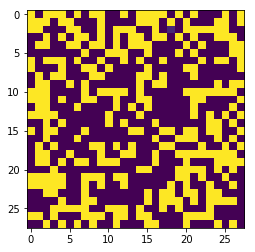

96


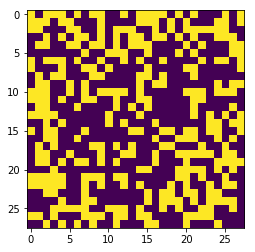

97


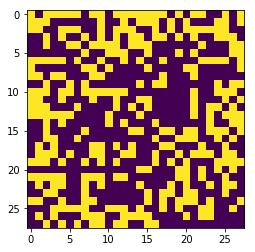

98


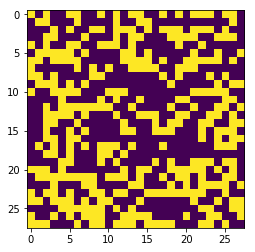

99


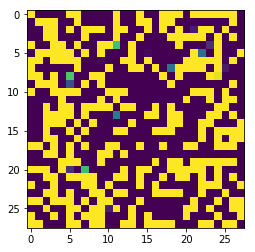

100


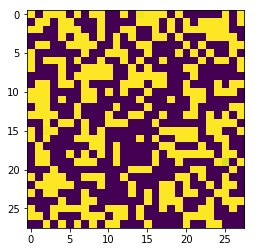

101


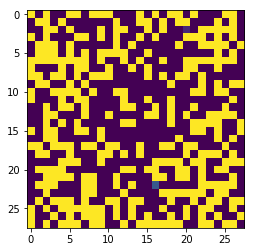

102


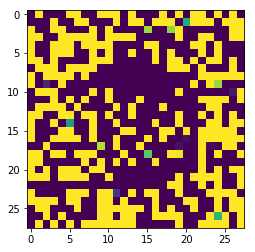

103


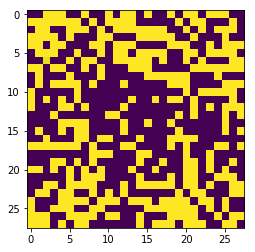

104


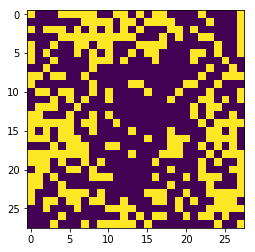

105


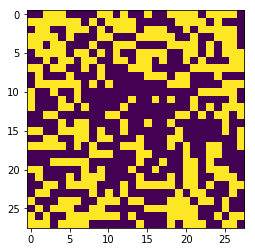

106


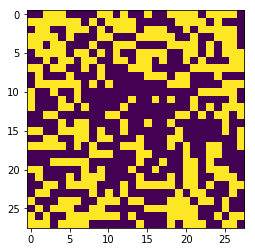

107


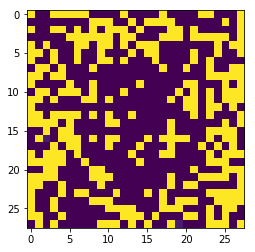

108


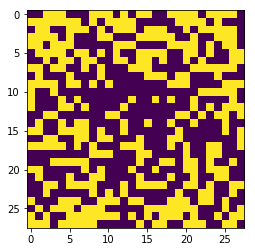

109


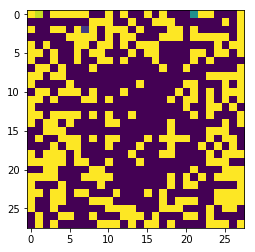

110


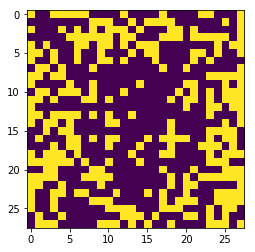

111


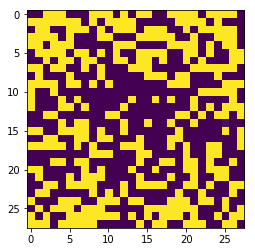

112


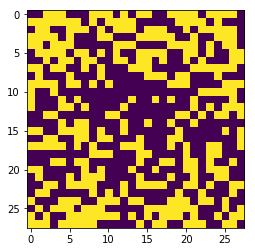

113


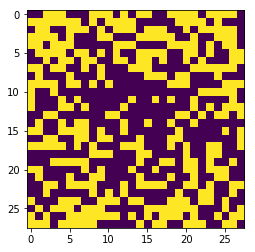

114


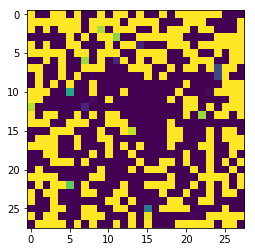

115


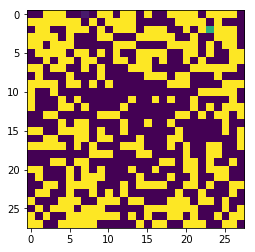

116


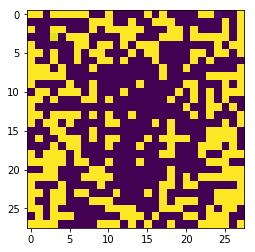

117


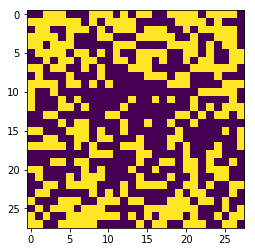

118


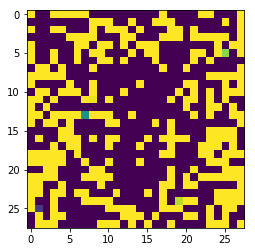

119


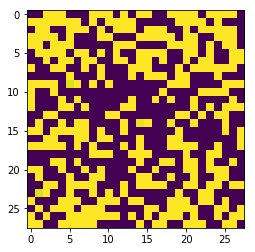

120


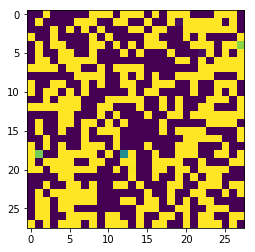

121


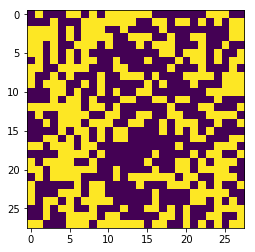

122


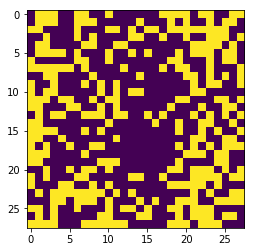

123


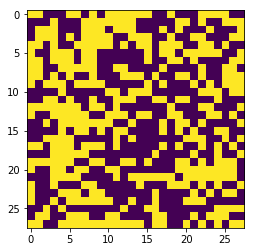

124


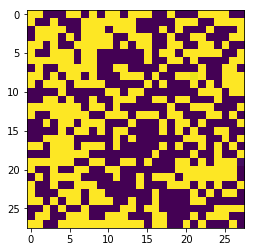

125


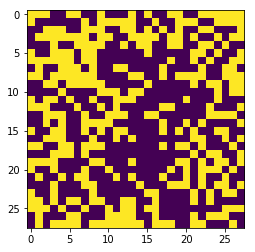

126


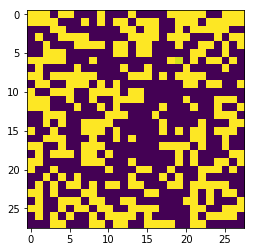

127


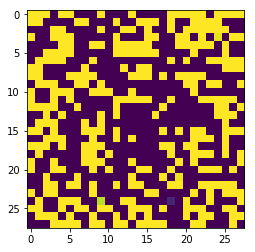

128


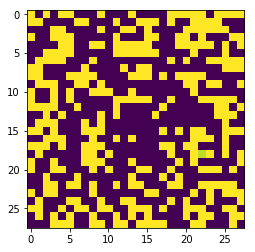

129


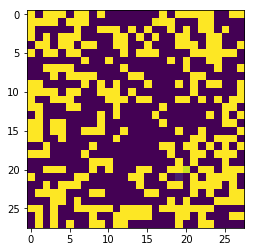

130


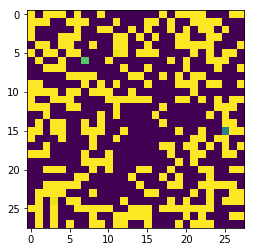

131


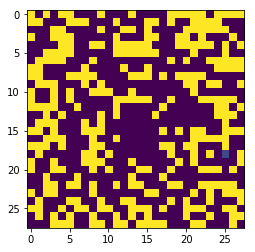

132


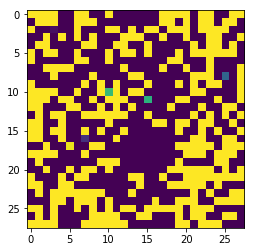

133


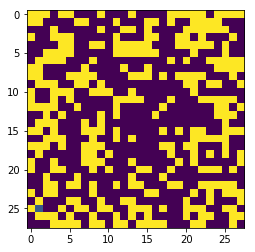

134


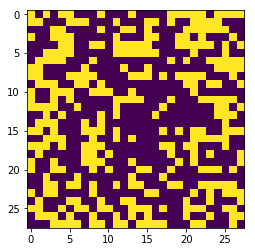

135


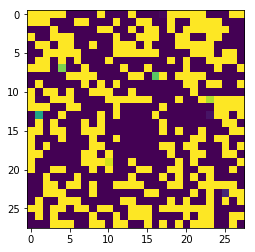

136


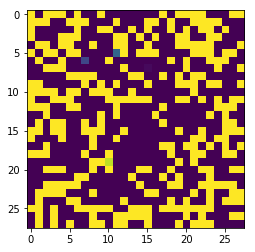

137


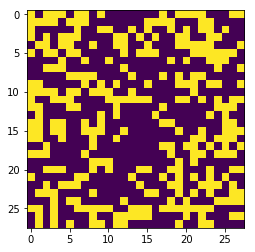

138


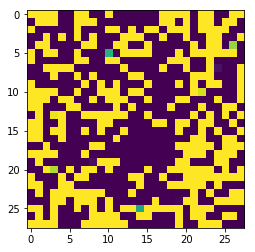

139


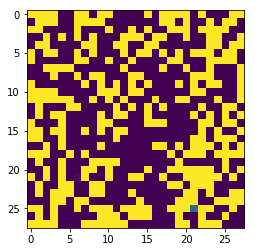

140


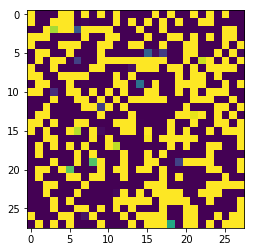

141


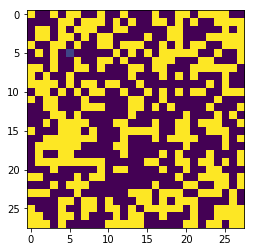

142


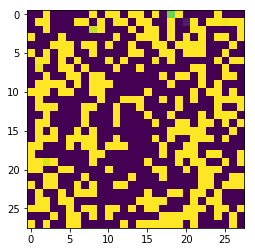

143


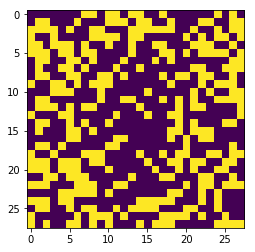

144


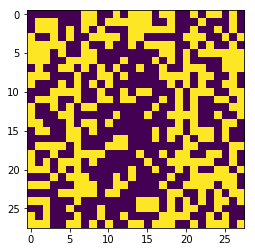

145


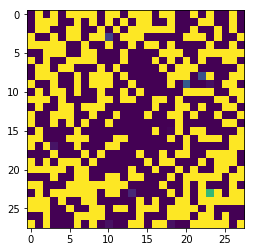

146


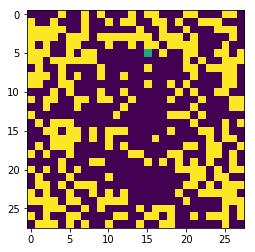

147


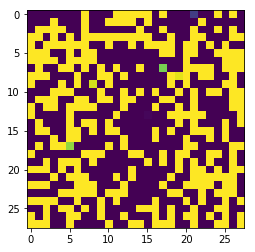

148


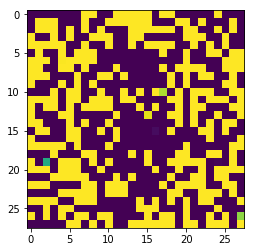

149


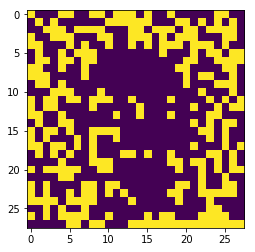

150


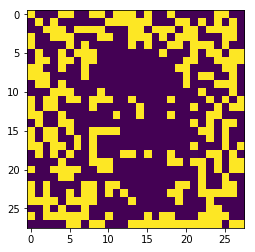

151


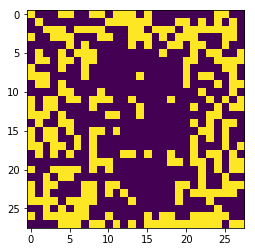

152


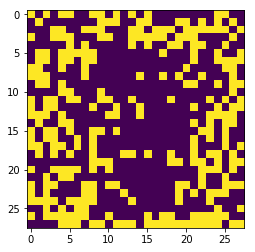

153


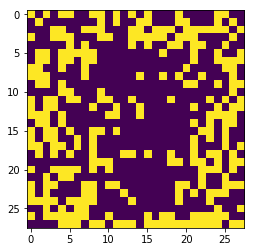

154


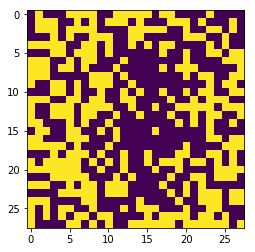

155


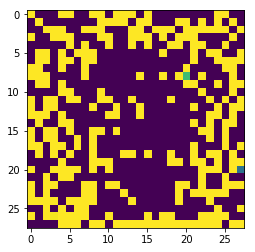

156


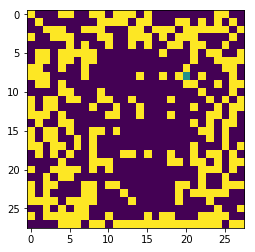

157


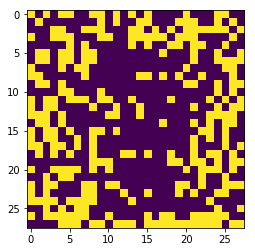

158


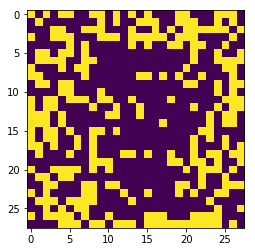

159


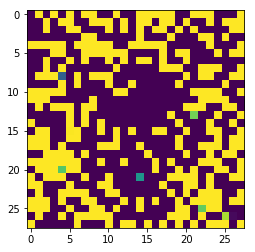

160


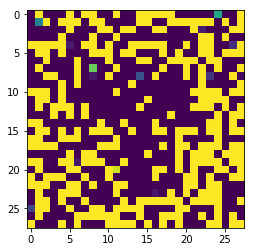

161


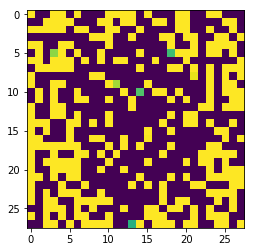

162


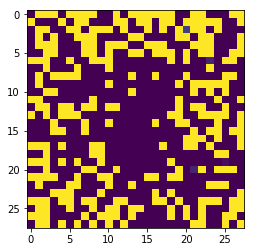

163


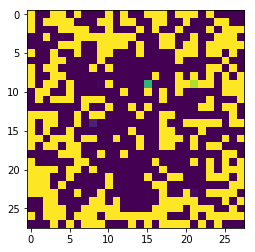

164


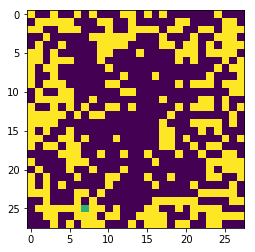

165


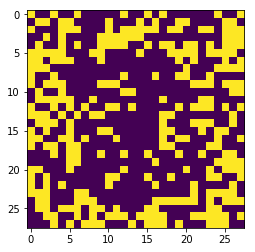

166


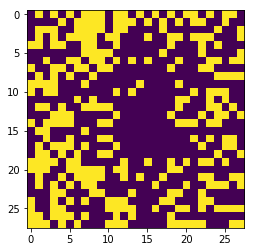

167


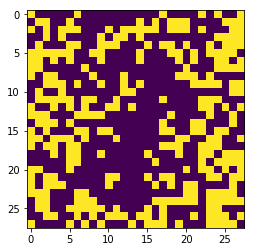

168


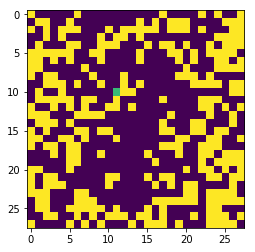

169


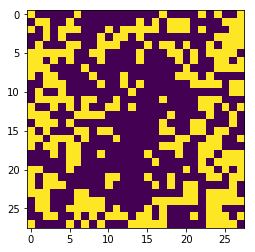

170


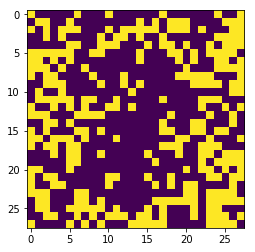

171


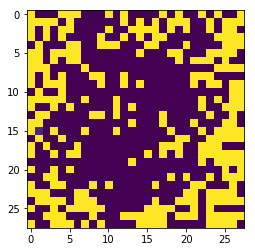

172


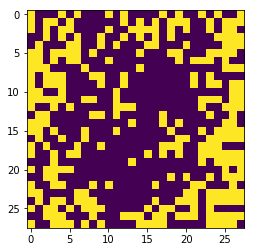

173


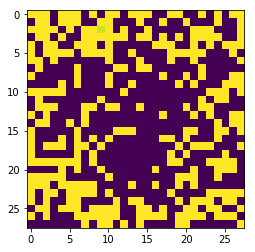

174


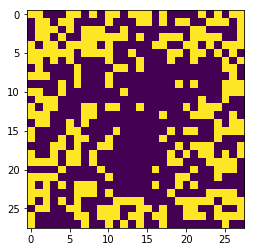

175


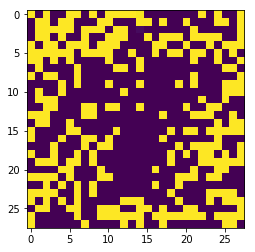

176


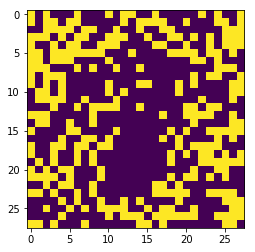

177


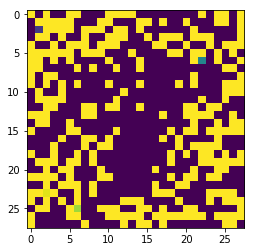

178


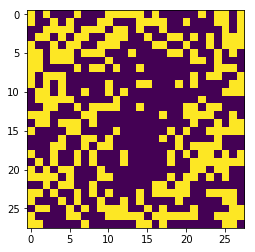

179


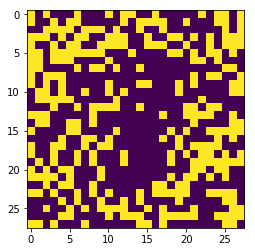

180


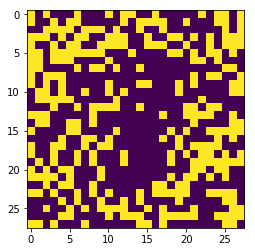

181


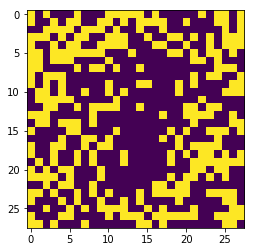

182


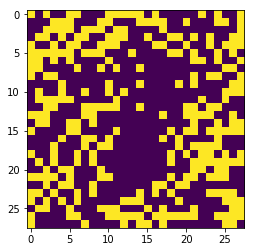

183


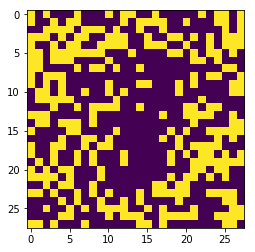

184


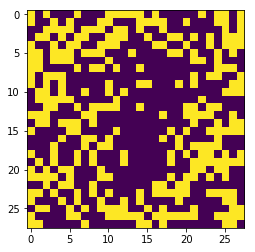

185


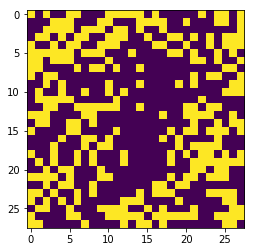

186


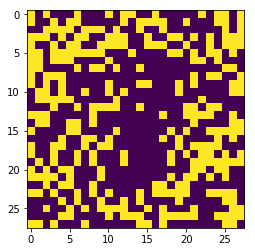

187


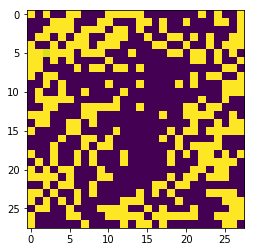

188


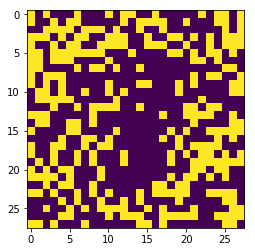

189


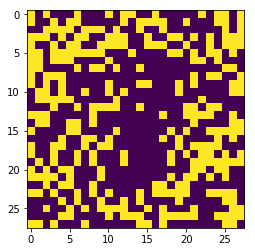

190


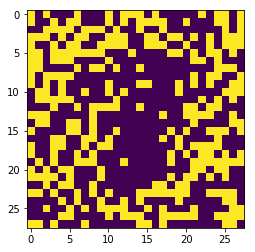

191


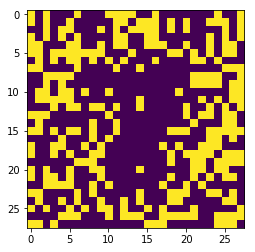

192


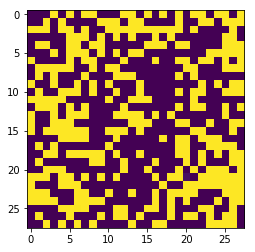

193


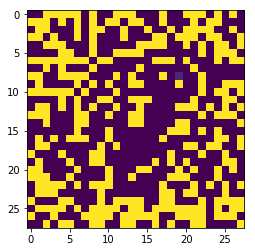

194


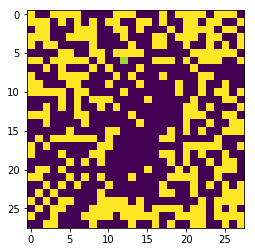

195


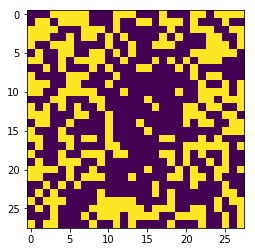

196


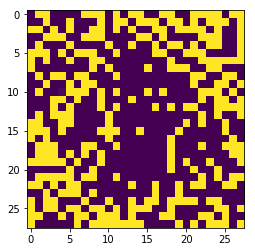

197


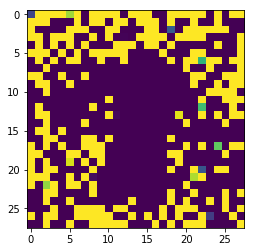

198


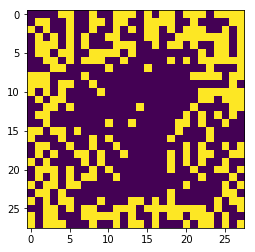

199


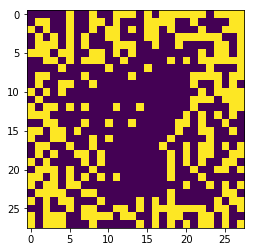

In [13]:
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    print(epoch)
    show_mnist_image(pd.DataFrame(generator(test_noise).detach().numpy()))
    
    for n_batch, real_batch in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)


In [14]:
torch.save(generator, "models/mnist_gan_generator_01")
torch.save(discriminator, "models/mnist_gan_discriminator_01")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneratorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DiscriminatorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
test_load_gen = torch.load("models/mnist_gan_generator_01")

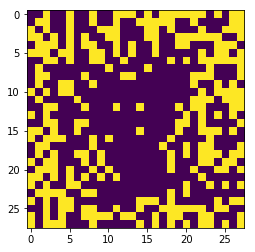

In [16]:
show_mnist_image(pd.DataFrame(generator(test_noise).detach().numpy()))